In [1]:
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rc
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')
mpl.rcParams['axes.unicode_minus'] = False

font_path = 'C:/font/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
# print(font_name)
rc('font', family=font_name)

endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema)
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

def load_data_from_rds(tabel_name):
  sql = "SELECT * FROM {}".format(tabel_name)
  df = pd.read_sql(sql, db_connection)
  return df

In [5]:
df = load_data_from_rds('MainData')
df.head()

,번호,위도,경도,생태통로_유형,차선_수,등산객_이용빈도,생태통로_효율성,이용확인종_수,폭(m),연장(m),...,식물군락명,등산로까지 최단거리(km),유도울타리_위도_2.3km,유도울타리_경도_2.3km,유도울타리_연장_m,유도울타리_높이_m,교통량,환경영향평가점수,건물까지거리(km),최우점식물군락
0,1495,35.36019,128.06375,0,1,1,3,0,NaN,NaN,...,소나무군락,3.157026,0.000000,0.000000,0,0.000000,7493.875000,2,0.196597,소나무
1,1277,37.03408,128.40661,1,0,0,3,0,NaN,NaN,...,소나무-신갈나무군락,1.087578,0.000000,0.000000,0,0.000000,3573.857143,1,0.358139,소나무
2,1278,36.89832,128.30563,1,0,0,1,3,NaN,NaN,...,소나무군락,3.070682,0.000000,0.000000,0,0.000000,3430.428571,2,0.139054,소나무
3,1279,36.89687,128.30581,1,0,0,1,3,NaN,NaN,...,소나무군락,2.921190,0.000000,0.000000,0,0.000000,3430.428571,2,0.044559,소나무
4,1090,36.71051,127.42222,0,2,5,1,3,8.23,38.0,...,아까시나무-리기다소나무식재림,0.025083,36.708802,127.437539,886,1.571429,34542.400000,5,0.172184,아까시나무


In [6]:
df['경사도'] = df['경사도'].astype('int64')
df = df.drop('식물군락명', axis = 'columns')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   번호                497 non-null    int64  
 1   위도                497 non-null    float64
 2   경도                497 non-null    float64
 3   생태통로_유형           497 non-null    int64  
 4   차선_수              497 non-null    int64  
 5   등산객_이용빈도          497 non-null    int64  
 6   생태통로_효율성          497 non-null    int64  
 7   이용확인종_수           497 non-null    int64  
 8   폭(m)              309 non-null    float64
 9   연장(m)             309 non-null    float64
 10  높이(m)             44 non-null     float64
 11  개방도               44 non-null     float64
 12  경사도               497 non-null    int64  
 13  주변 로드킬 빈도         497 non-null    int64  
 14  산책로까지의 최단 거리(km)  497 non-null    float64
 15  농가까지의 거리(km)      497 non-null    float64
 16  도로 최고제한속도(km/h)   497 non-null    int64  
 1

In [7]:
# 생태통로 유형별
df_overpass = df[df['생태통로_유형']==0]
df_overpass.drop(['높이(m)', '개방도'], axis=1, inplace=True)
df_tunnel = df[df['생태통로_유형']==1]
# df_tunnel = df[(df['생태통로_유형']==1)|(df['생태통로_유형']==2)]

In [2]:
# 결측치 비율
def missing_ratio(df):
    df_over_null = df.isnull().sum().reset_index()
    df_over_null.columns = ['column', 'count']
    df_over_null['ratio'] = df_over_null['count']/len(df)
    df_over_null= df_over_null[df_over_null['ratio'] != 0]
    display(df_over_null)

#명목형(Norminal)
def norminal_feature(df):
    nom_feature = ['생태통로_효율성', '최우점식물군락']

    fig = plt.figure(figsize=(15,6))
    for i, col in enumerate(nom_feature):
        ax = fig.add_subplot(1,2, i+1)
        df[col].value_counts().plot(kind='bar')
        ax.set_title(col)
    plt.show()

#순서형(Ordinal) 그래프
def ordinal_feature(df):
    ord_feature = ['등산객_이용빈도', '경사도', '환경영향평가점수']

    fig = plt.figure(figsize=(30,20))
    for i, col in enumerate(ord_feature):
        ax = fig.add_subplot(2,2,i+1)
        df[col].value_counts().plot(kind='bar')
        ax.set_title(col)
    plt.show()

#수치형 그래프
def numerical_feature(df):
    num_feature = ['차선_수', '폭(m)', '연장(m)', '높이(m)', '개방도', '주변 로드킬 빈도', '산책로까지의 최단 거리(km)',
       '농가까지의 거리(km)', '도로 최고제한속도(km/h)', '주변 동물종 개수', '주변동물 출현빈도',
       '하천거리(km)', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']

    fig = plt.figure(figsize=(20,30))
    i = 0
    for col in num_feature:
        try:
            ax = fig.add_subplot(8,2, i+1)
            sns.distplot(df.loc[df[col].notnull(), col])
            ax.set_title(col)
            i+=1
        except :
            continue
    plt.tight_layout()
    plt.show()

def EDA(df):
    print('결측치 비율')
    missing_ratio(df)
    print('명목형 변수')
    norminal_feature(df)
    print('순서형 변수')
    ordinal_feature(df)
    print('수치형 변수')
    numerical_feature(df)

# 육교형

In [9]:
# EDA(df_overpass)

# 터널형

In [10]:
# EDA(df_tunnel)

# Post Processing

# 결측치 제거

In [23]:
overpass_outlier_path = '.././data/overpass_outlier_차선수.csv'
overpass_outlier = pd.read_csv(overpass_outlier_path, encoding='cp949')
tunnel_outlier_path = '.././data/tunnel_outlier_차선수.csv'
tunnel_outlier = pd.read_csv(tunnel_outlier_path, encoding='cp949')

결측치 비율


,column,count,ratio
7,폭(m),36,0.12
8,연장(m),36,0.12


명목형 변수


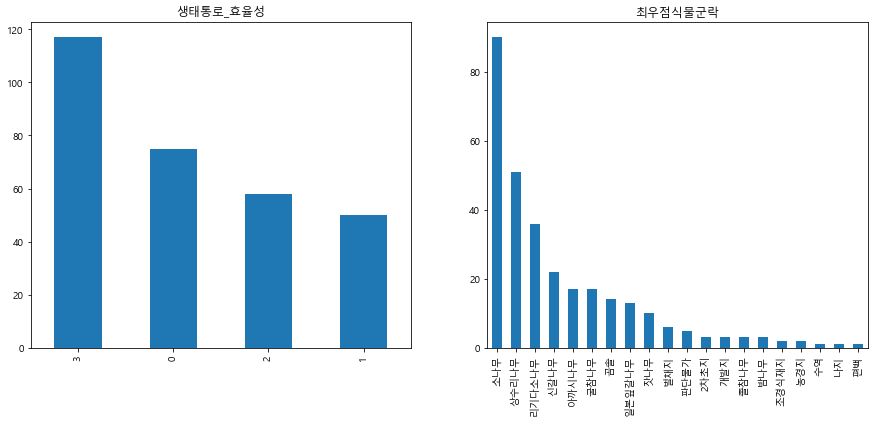

순서형 변수


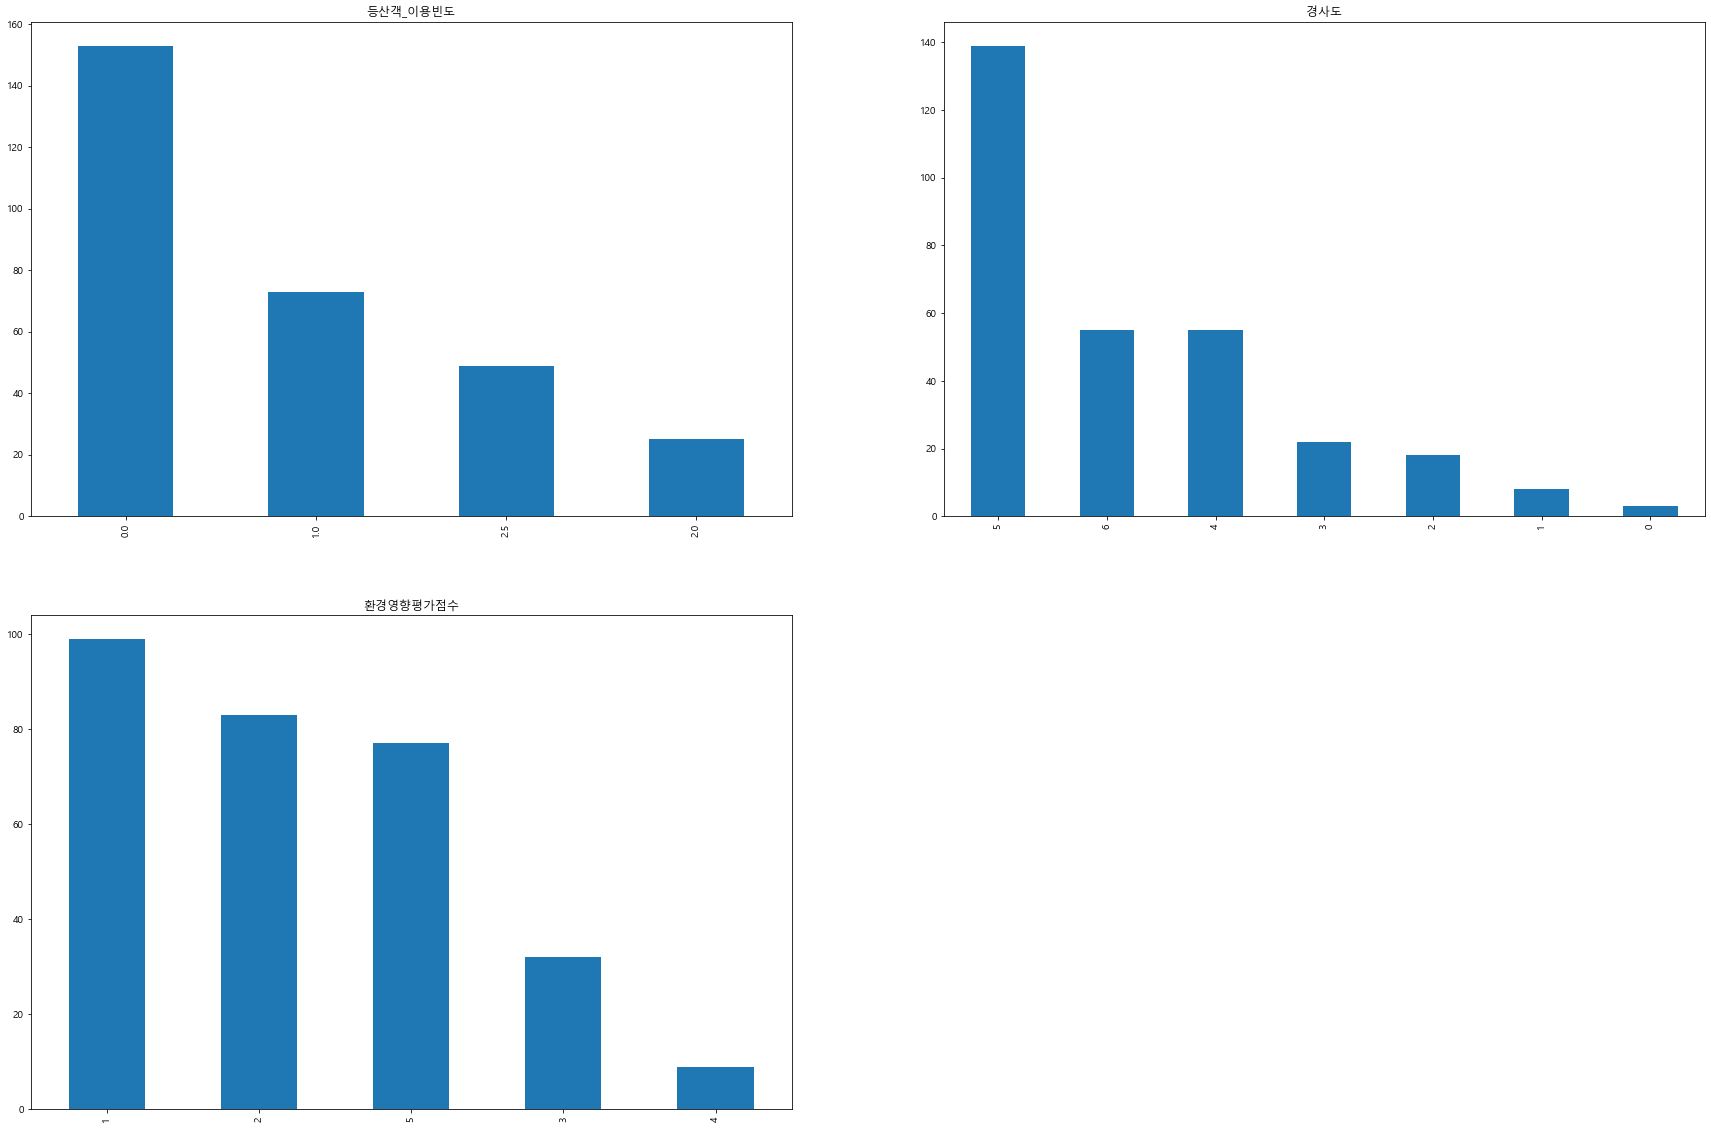

수치형 변수


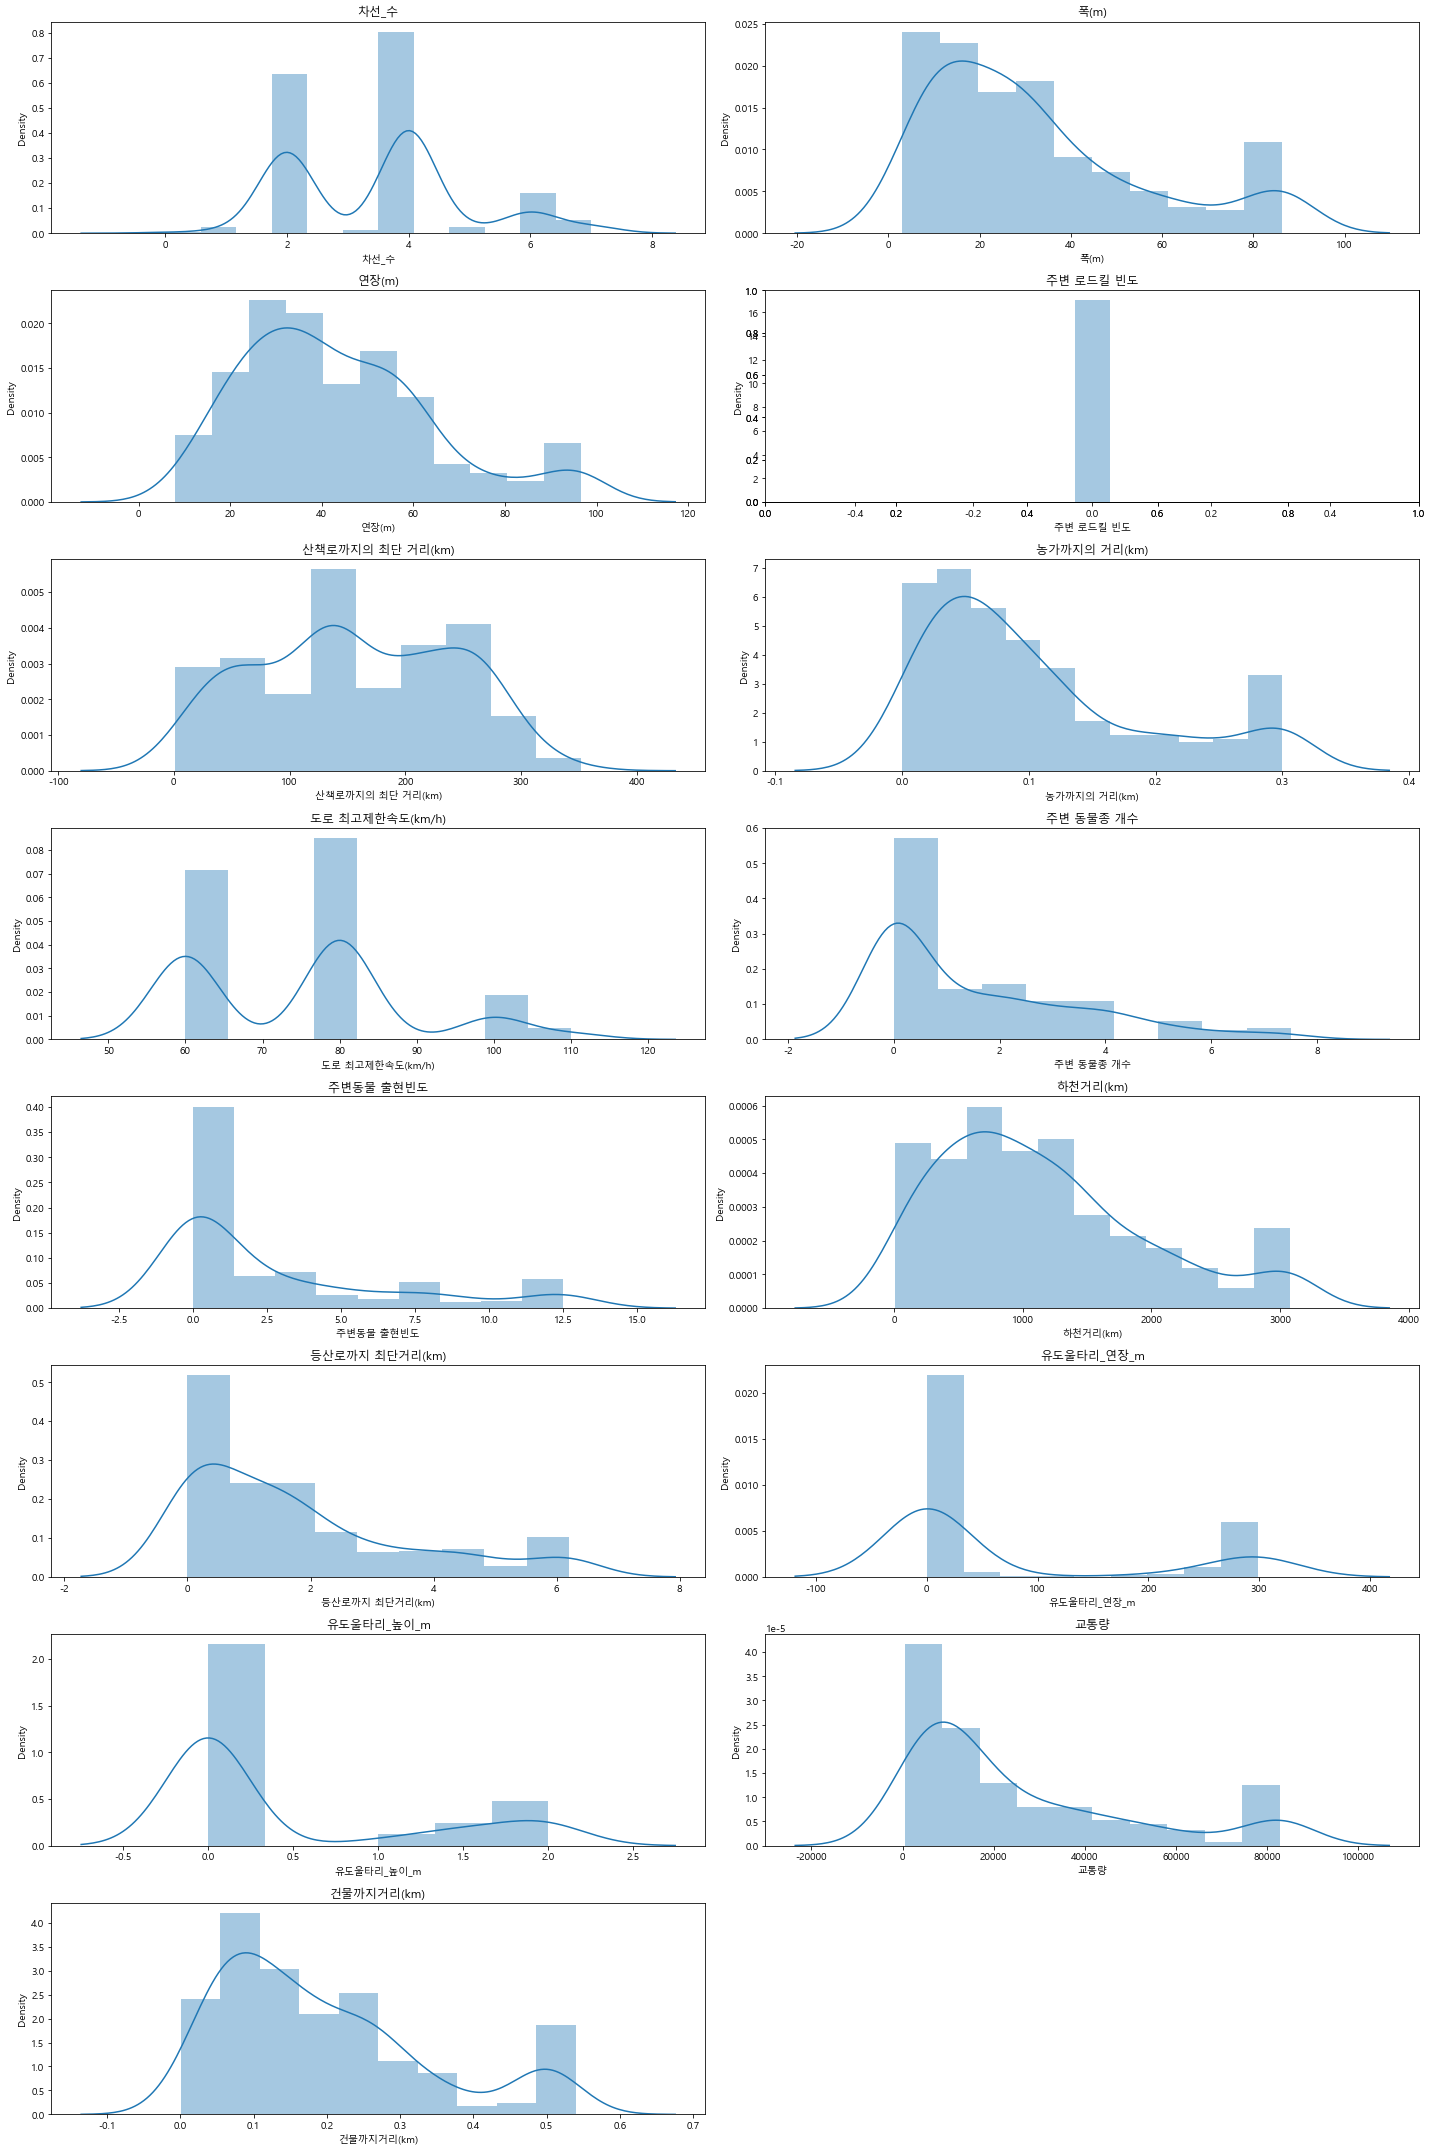

In [26]:
# overpass_outlier.csv
EDA(overpass_outlier)

In [25]:
overpass_outlier[['폭(m)','연장(m)']].describe()

,폭(m),연장(m)
count,264.000000,264.000000
mean,32.092917,43.435038
std,23.804778,20.913774
min,3.000000,8.000000
25%,13.150000,28.600000
50%,27.000000,39.350000
75%,42.450000,55.800000
max,86.400000,96.600000


In [ ]:
# tunnel_outlier.csv
#df = pd.read_csv(tunnel_list[-1], encoding='cp949')
#EDA(df)

In [27]:
tunnel_outlier[['폭(m)','연장(m)']].describe()

,폭(m),연장(m)
count,45.000000,45.000000
mean,3.966667,30.755556
std,2.381272,16.706498
min,0.900000,4.500000
25%,2.000000,17.000000
50%,3.500000,30.700000
75%,5.000000,37.000000
max,9.500000,67.000000


# 최종 결과 확인

In [3]:
overpass_list = glob('.././data/MainData_cases/*overpass*.csv')
overpass_list = glob('.././data/MainData_차선수/*overpass*.csv')
overpass_list = [p.replace('\\', '/') for p in overpass_list]
# print(overpass_list)
# tunnel_list = glob('.././data/MainData_cases/*tunnel*.csv')
tunnel_list = glob('.././data/MainData_차선수/*tunnel*.csv')
tunnel_list = [p.replace('\\', '/') for p in tunnel_list]
# print(tunnel_list)

결측치 비율


,column,count,ratio


명목형 변수


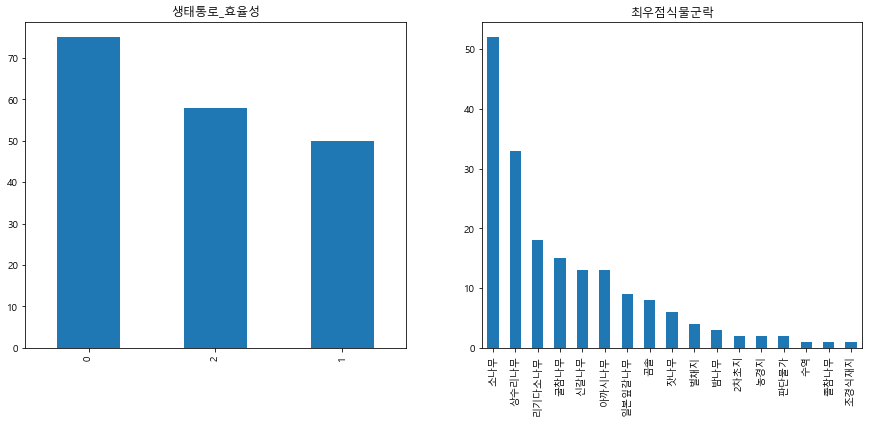

순서형 변수


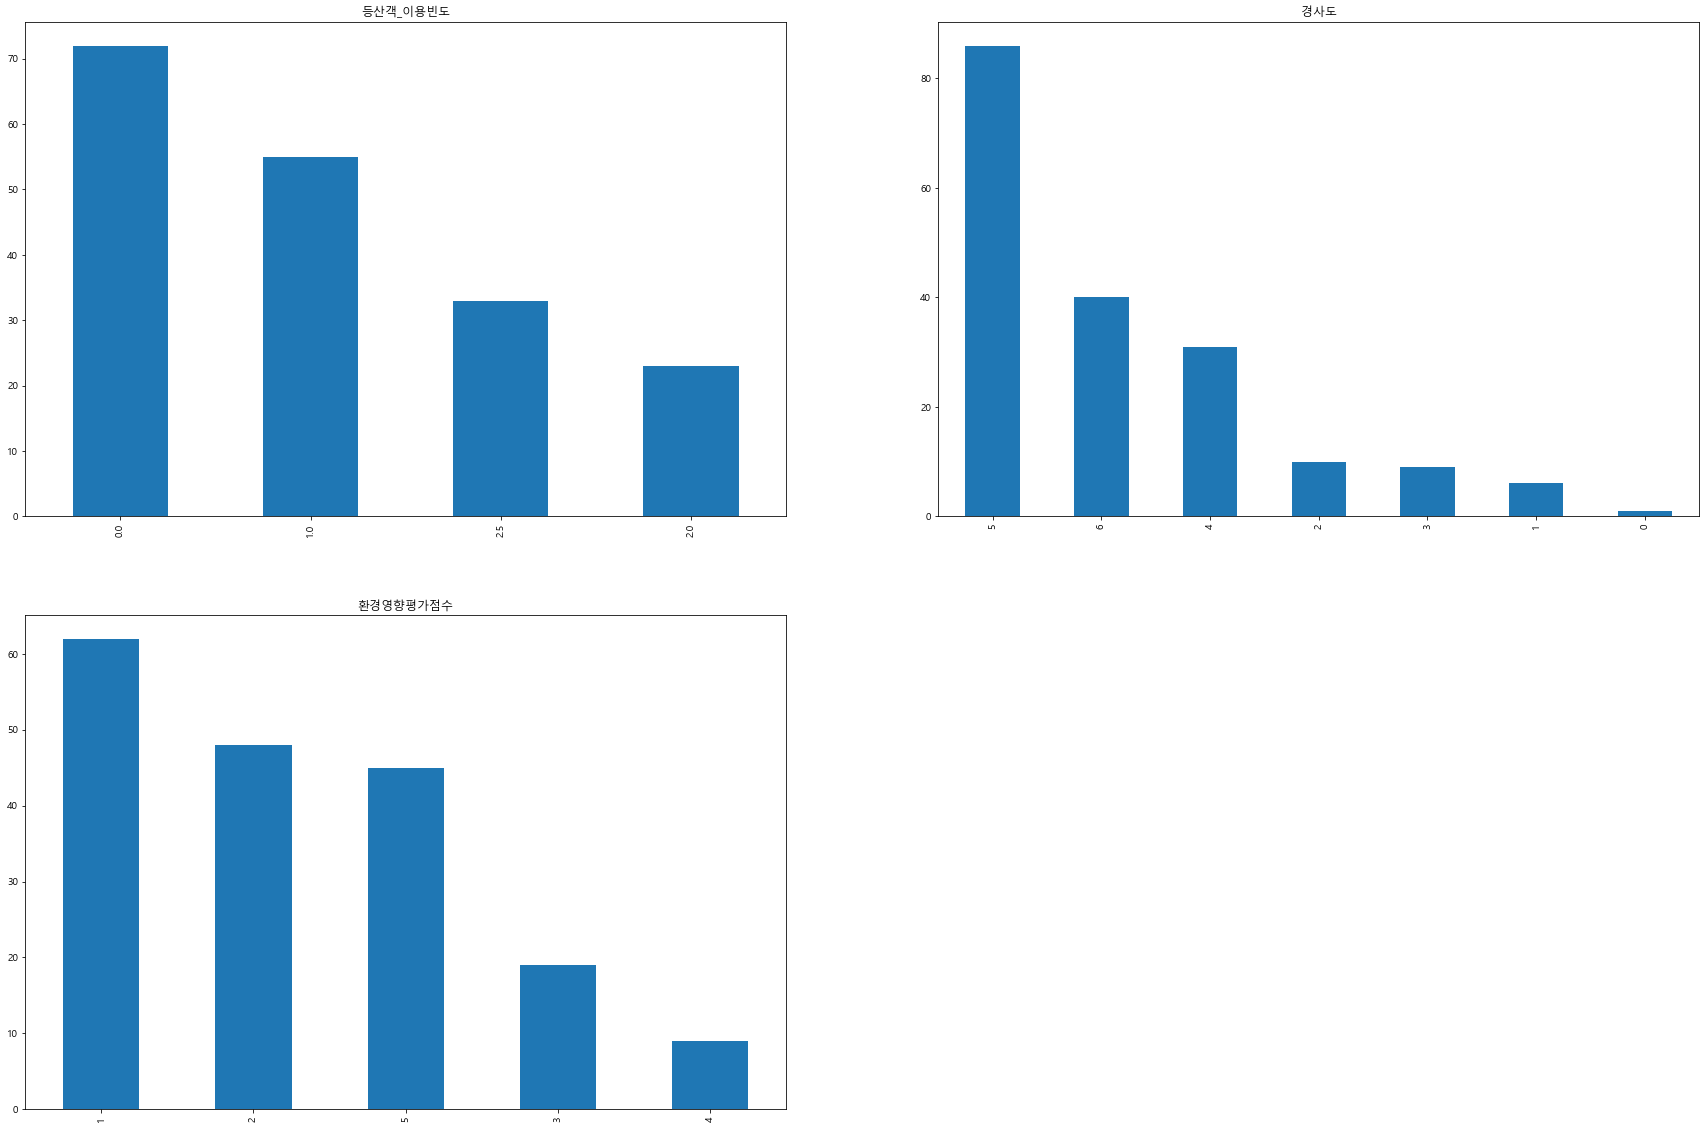

수치형 변수


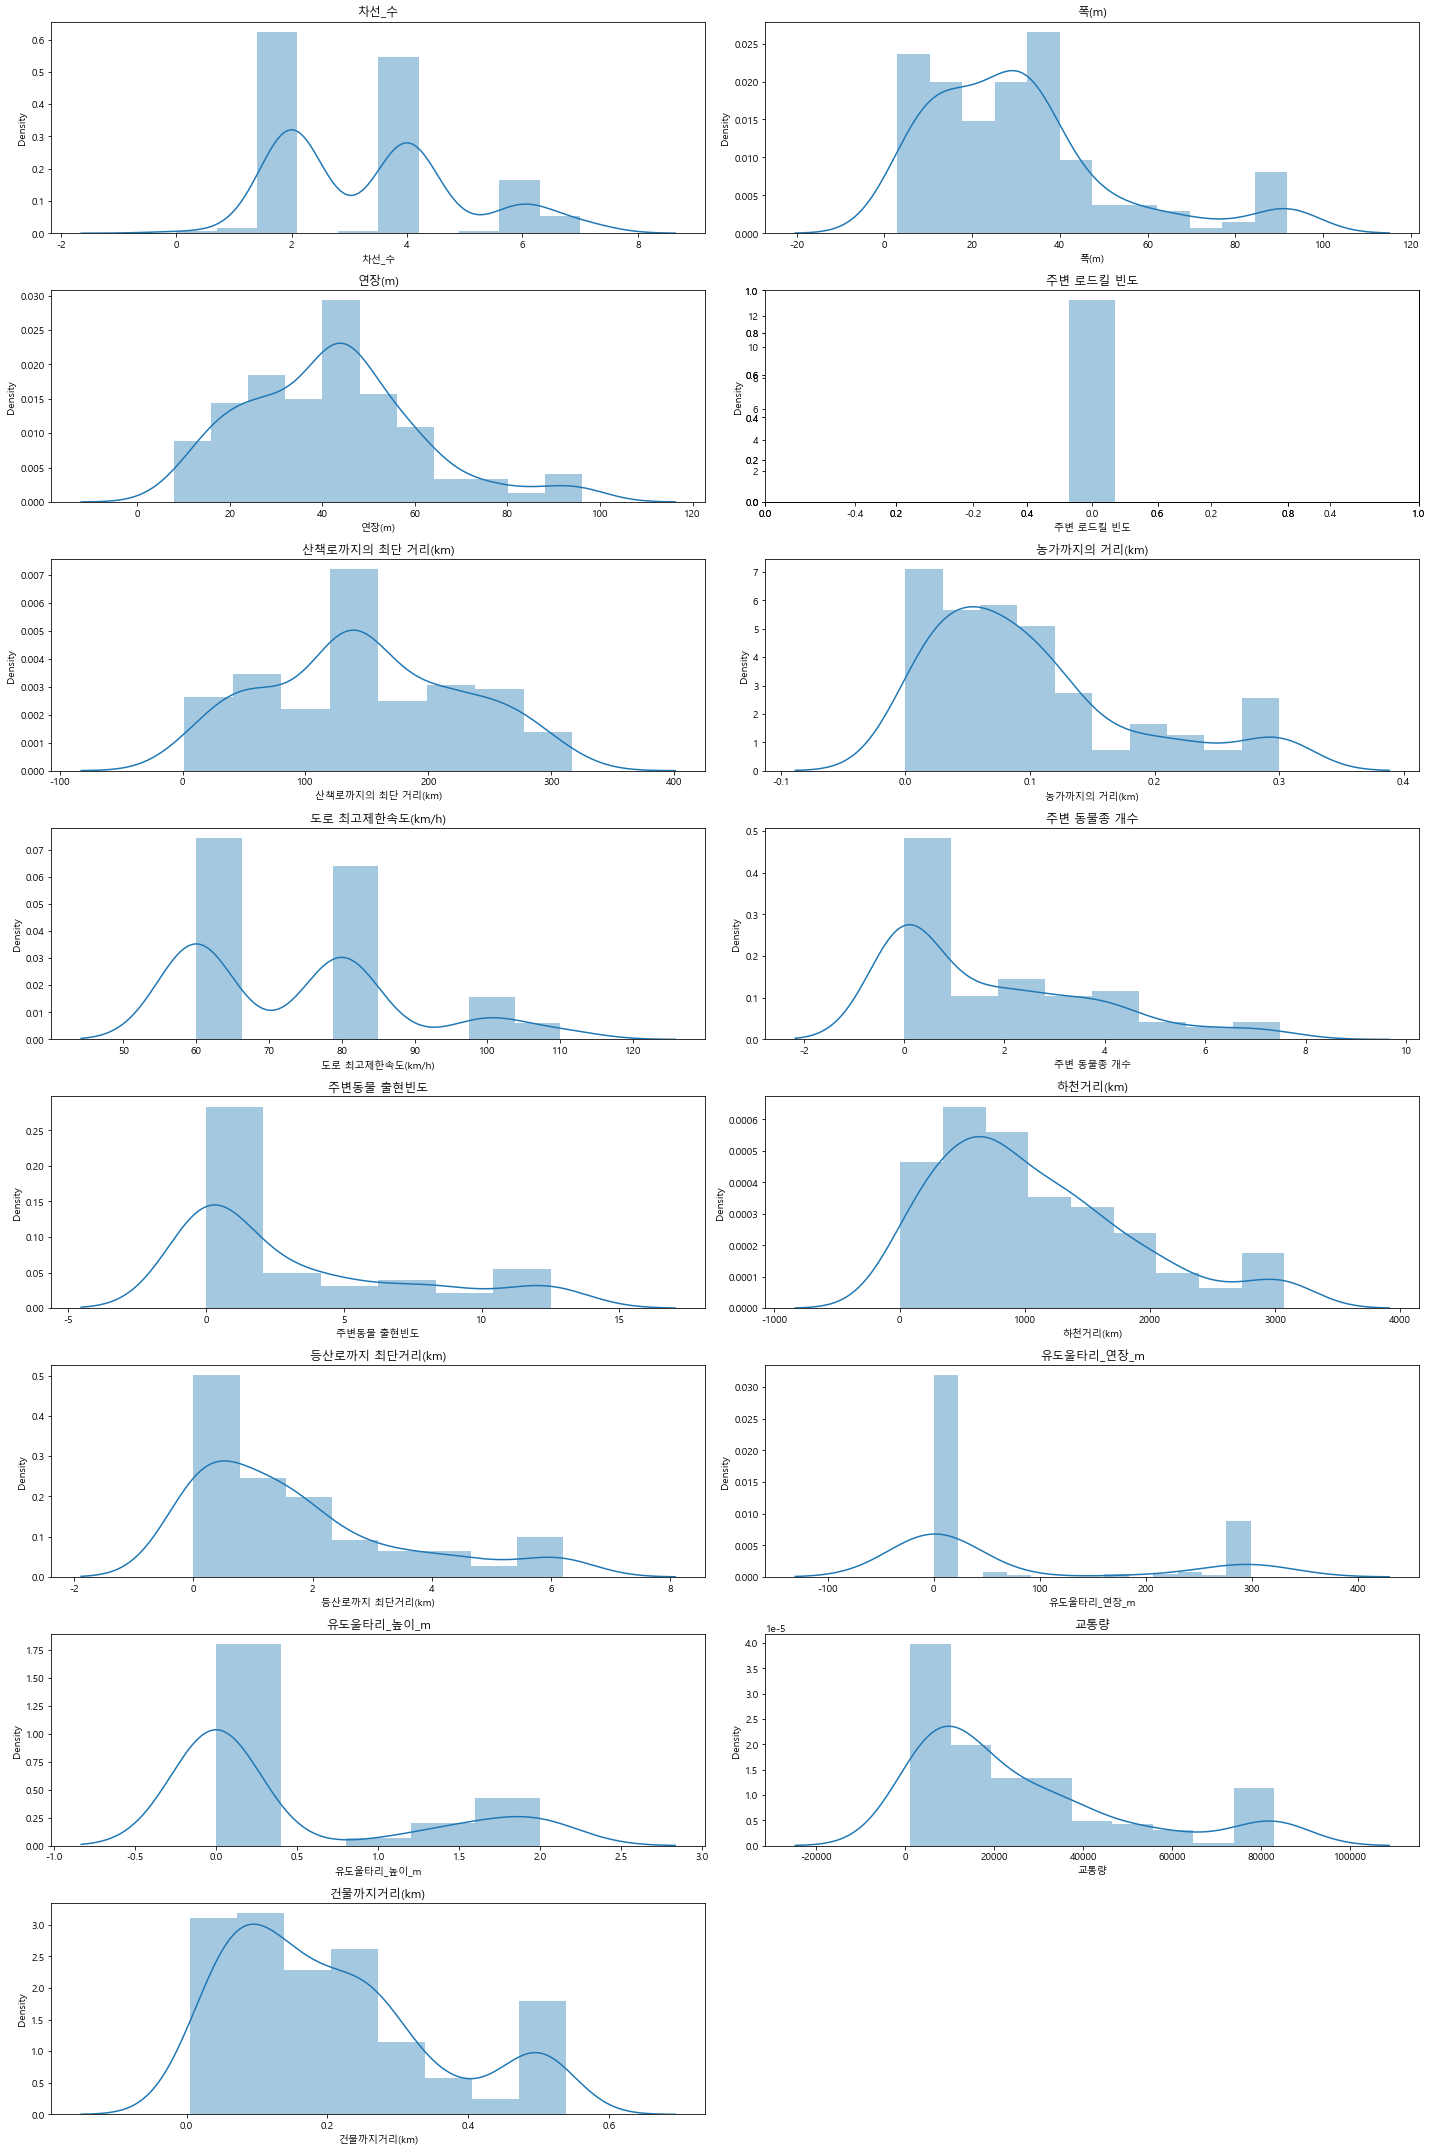

In [4]:
#overpass_knn3_drop.csv
EDA(pd.read_csv(overpass_list[4], encoding='cp949'))

In [ ]:
# tunnel_knn3_drop.csv
# EDA(pd.read_csv(tunnel_list[4], encoding='cp949'))

In [ ]:
#overpass_knn3_median.csv
# df = pd.read_csv(overpass_list[5], encoding='cp949')
# EDA(df)

In [ ]:
# tunnel_knn3_median.csv
# EDA(pd.read_csv(tunnel_list[5], encoding='cp949'))